Import libraries

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import glob
from lxml import etree
from sklearn.model_selection import train_test_split
from tensorflow import keras

Display files in dataset

In [20]:
for dirname, _, filenames in os.walk('./dataset'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

./dataset\image\0.jpg
./dataset\image\1.jpg
./dataset\image\10.jpg
./dataset\image\100.jpg
./dataset\image\101.jpg
./dataset\image\102.jpg
./dataset\image\103.jpg
./dataset\image\104.jpg
./dataset\image\105.jpg
./dataset\image\106.jpg
./dataset\image\107.jpg
./dataset\image\108.jpg
./dataset\image\109.jpg
./dataset\image\11.jpg
./dataset\image\110.jpg
./dataset\image\111.jpg
./dataset\image\112.jpg
./dataset\image\113.jpg
./dataset\image\114.jpg
./dataset\image\115.jpg
./dataset\image\116.jpg
./dataset\image\117.jpg
./dataset\image\118.jpg
./dataset\image\119.jpg
./dataset\image\12.jpg
./dataset\image\120.jpg
./dataset\image\121.jpg
./dataset\image\122.jpg
./dataset\image\123.jpg
./dataset\image\124.jpg
./dataset\image\125.jpg
./dataset\image\126.jpg
./dataset\image\127.jpg
./dataset\image\128.jpg
./dataset\image\129.jpg
./dataset\image\13.jpg
./dataset\image\130.jpg
./dataset\image\131.jpg
./dataset\image\132.jpg
./dataset\image\133.jpg
./dataset\image\134.jpg
./dataset\image\135.jpg


In [21]:
IMG_SIZE = 224

In [22]:
# Directory of all images
img_dir = "./dataset/image"
data_path = os.path.join(img_dir, '*jpg')
files = glob.glob(data_path)

# We sort the images in alphabetical order to match them to the xml files containing the annotations of the bounding boxes
files.sort()
X = []

for file in files:
    image = cv2.imread(file)
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    X.append(np.array(image))

We create the variable y containing all the bounding boxe annotations (label). Before that, we will have to resize the annotations so that it fits the new size of the images (200*200). We create a function resizeannotation for that.

In [23]:
def resize_annotation(file):
    tree = etree.parse(file)
    for dim in tree.xpath("size"):
        width = int(dim.xpath("width")[0].text)
        height = int(dim.xpath("height")[0].text)
    for dim in tree.xpath("object/bndbox"):
        xmin = int(dim.xpath("xmin")[0].text)/(width/IMG_SIZE)
        ymin = int(dim.xpath("ymin")[0].text)/(height/IMG_SIZE)
        xmax = int(dim.xpath("xmax")[0].text)/(width/IMG_SIZE)
        ymax = int(dim.xpath("ymax")[0].text)/(height/IMG_SIZE)
    return [int(xmax), int(ymax), int(xmin), int(ymin)]

In [24]:
path = "./dataset/label_xml"
xml_files = ['./dataset/label_xml/' + f for f in sorted(os.listdir(path))]
y = []
for file in xml_files:
    y.append(resize_annotation(file))

In [25]:
resize_annotation("./dataset/label_xml/20.xml")

[91, 54, 66, 47]

Check X and y shape

In [26]:
np.array(X).shape

(388, 224, 224, 3)

In [27]:
np.array(y).shape

(388, 4)

### TODO: We should to filter xml files

Display first fifteen image of the dataset

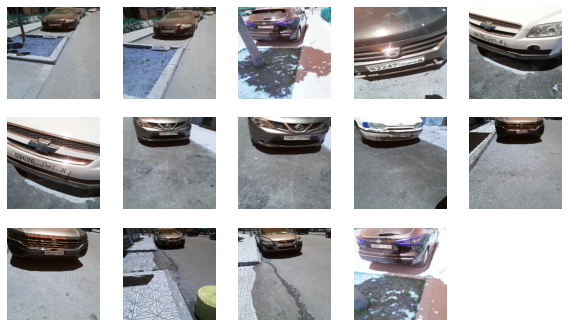

In [28]:
plt.figure(figsize=(10, 20))
for i in range(0, 14):
    plt.subplot(10, 5, i+1)
    plt.axis('off')
    plt.imshow(X[i])

We can draw the rectangle containing the license plate using the OpenCV library

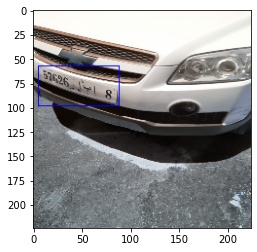

In [29]:
# Example with the first image of the dataset
image = cv2.rectangle(X[4], (y[4][0], y[4][1]), (y[4][2], y[4][3]), (0, 0, 255))
plt.imshow(image)
plt.show()

### We prepare the data for CNN

In [30]:
# Transforming in array
X = np.array(X)
y = np.array(y)

In [31]:
# Renormalisation
X = X / 255
y = y / 255

Splitting dataset into : Training set | Testing set | Validation set

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=1)

# Convolutionnal Neural Network

In [38]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.applications.vgg16 import VGG16

In [40]:
# Create model
model = Sequential()
model.add(VGG16(weights="imagenet", include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3)))
model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dense(128, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dense(4, activation="sigmoid"))

model.layers[-6].trainable = False

model.summary()

58892288/58889256 [==============================] - 14s 0us/step
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               3211392   
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 260       
Total params: 17,951,108
Trainable params: 3,236,420
N

In [41]:
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

In [42]:
train = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=32, verbose=1)

Epoch 1/50
9/9 [==============================] - 58s 6s/step - loss: 0.0498 - accuracy: 0.6344 - val_loss: 0.0230 - val_accuracy: 0.8710
Epoch 2/50
9/9 [==============================] - 65s 7s/step - loss: 0.0157 - accuracy: 0.8208 - val_loss: 0.0212 - val_accuracy: 0.7097
Epoch 3/50
9/9 [==============================] - 66s 7s/step - loss: 0.0093 - accuracy: 0.8172 - val_loss: 0.0172 - val_accuracy: 0.8065
Epoch 4/50
9/9 [==============================] - 64s 7s/step - loss: 0.0059 - accuracy: 0.8710 - val_loss: 0.0153 - val_accuracy: 0.8387
Epoch 5/50
9/9 [==============================] - 58s 6s/step - loss: 0.0044 - accuracy: 0.8638 - val_loss: 0.0142 - val_accuracy: 0.8065
Epoch 6/50
9/9 [==============================] - 58s 6s/step - loss: 0.0031 - accuracy: 0.8889 - val_loss: 0.0148 - val_accuracy: 0.8065
Epoch 7/50
9/9 [==============================] - 58s 6s/step - loss: 0.0022 - accuracy: 0.8889 - val_loss: 0.0163 - val_accuracy: 0.8065
Epoch 8/50
9/9 [==================

In [43]:
model.save('my_model.h5', overwrite=True) 

In [44]:
# Test
scores = model.evaluate(X_test, y_test, verbose=0)
print("Score : %.2f%%" % (scores[1]*100))

Score : 88.46%


In [45]:
def plot_scores(train) :
    accuracy = train.history['accuracy']
    val_accuracy = train.history['val_accuracy']
    epochs = range(len(accuracy))
    plt.plot(epochs, accuracy, 'b', label='Score apprentissage')
    plt.plot(epochs, val_accuracy, 'r', label='Score validation')
    plt.title('Scores')
    plt.legend()
    plt.show()

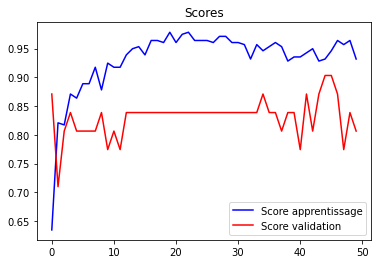

In [46]:
plot_scores(train)

## Detection

In [48]:
test_loss, test_accuracy = model.evaluate(X_test, y_test,steps=int(100))

print("Test results \n Loss:",test_loss,'\n Accuracy',test_accuracy)

 78/100 [======================>.......] - 19s 243ms/step - loss: 0.0064 - accuracy: 0.8846
Test results 
 Loss: 0.006366483401507139 
 Accuracy 0.8846153616905212


In [49]:
y_cnn = model.predict(X_test)

We can see how our model localize license plates on our testing set :

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

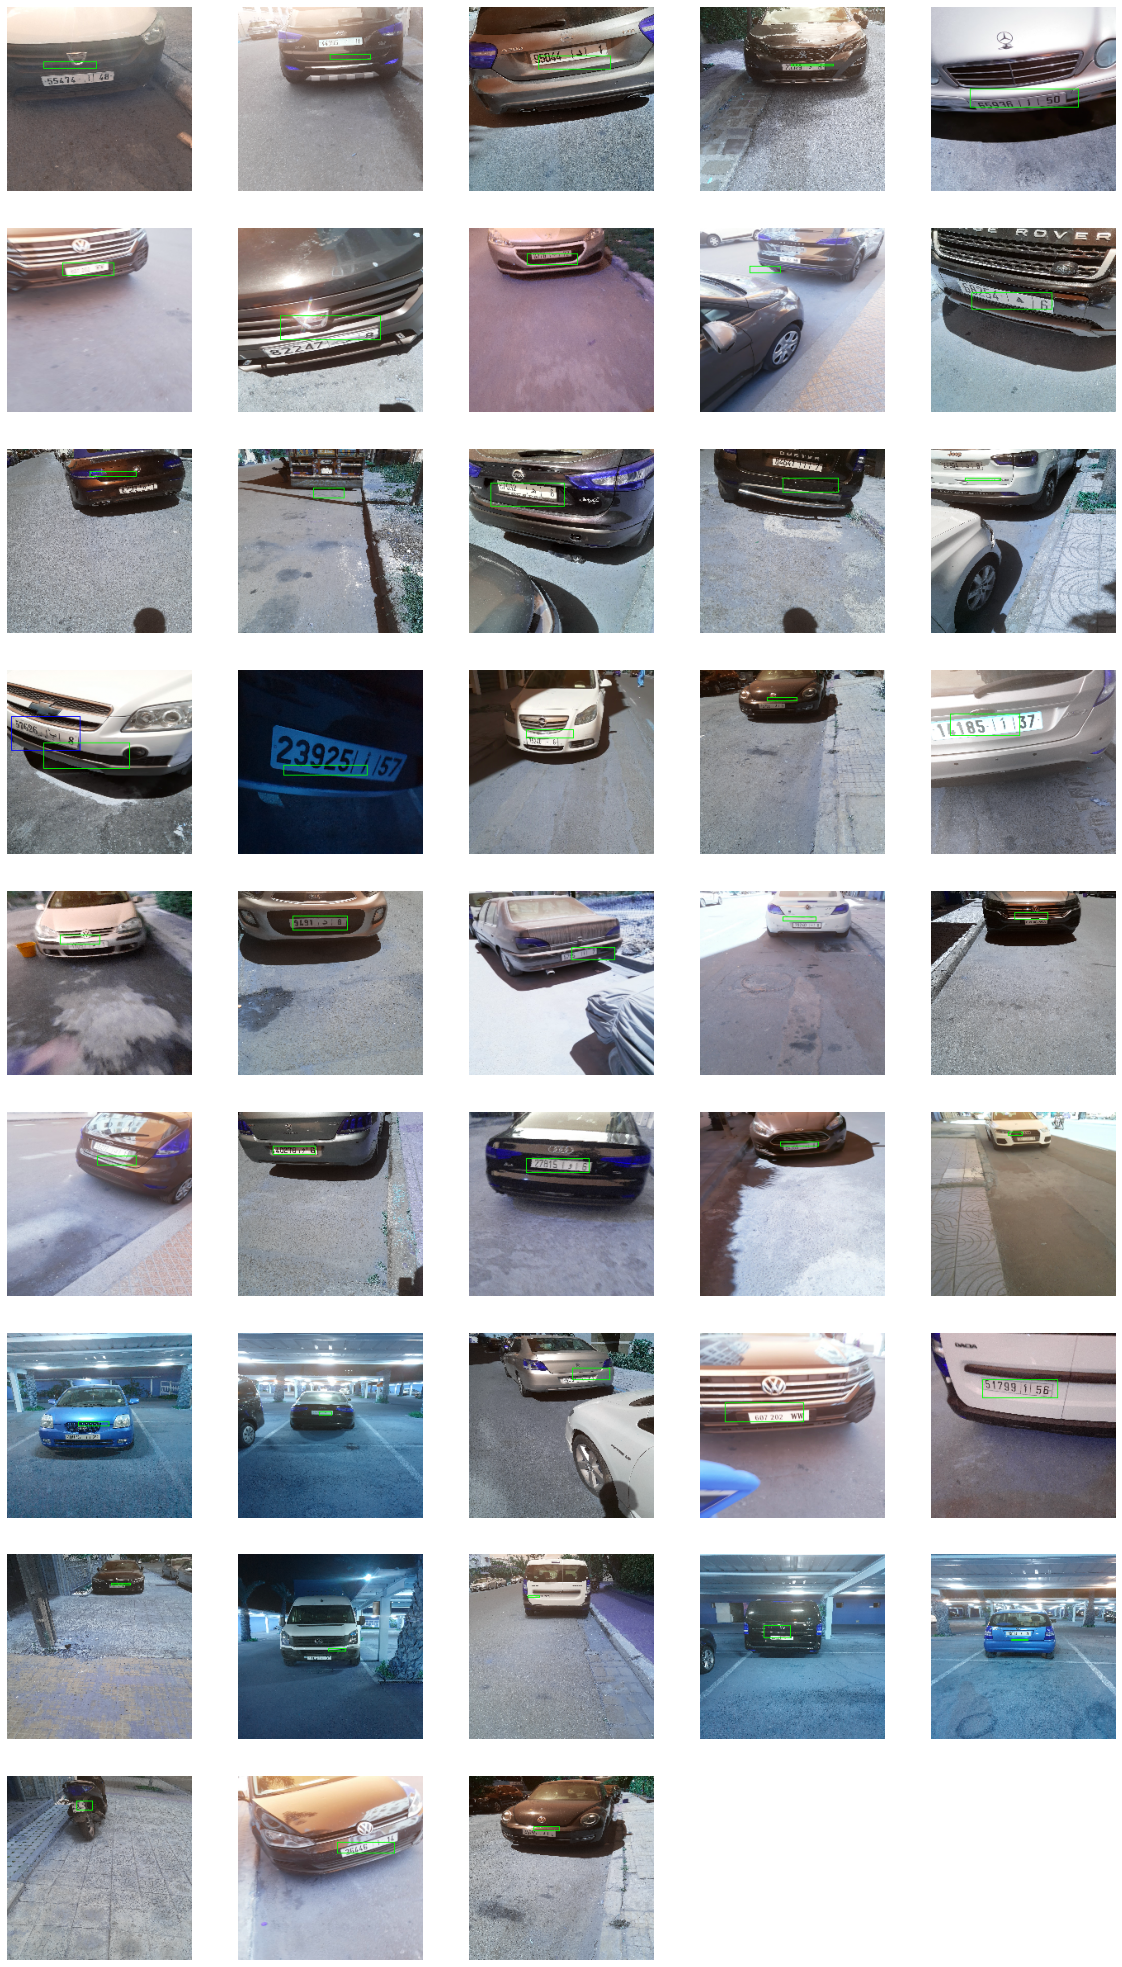

In [50]:
plt.figure(figsize=(20,40))
for i in range(0,43) :
    plt.subplot(10,5,i+1)
    plt.axis('off')
    ny = y_cnn[i]*255
    image = cv2.rectangle(X_test[i],(int(ny[0]),int(ny[1])),(int(ny[2]),int(ny[3])),(0, 255, 0))
    plt.imshow(image)